In [25]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# !pip install shap
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## Disclaimer: The code below summarizes the key steps in our data pipeline. Please note that additional models, feature engineering techniques, and preprocessing methods were explored during development but are not included here, as this notebook is intended to showcase only the most impactful highlights.

# Dataset Description

This dataset combines two data sources: the **California Department of Insurance Homeowners Insurance Study** and **CAL FIRE Damage Inspection (DINS) Data**. It captures details on structural damage from fire incidents along with associated insurance policy information. This integration enables an analysis of how wildfires impact insured properties and offers insights into policy coverage, structural vulnerabilities, and the financial burden on homeowners.

- **Source 1:** [California Department of Insurance Homeowners Study](https://www.insurance.ca.gov/0400-news/0200-studies-reports/0250-homeowners-study/#A) provides details about policies, premiums, exposures, and fire coverage amounts by policy type.
- **Source 2:** [CAL FIRE DINS Data](https://data.ca.gov/dataset/cal-fire-damage-inspection-dins-data) records specific fire incidents, structural attributes, damage severity, and defense actions taken.

---

## Schema Overview

### 1. Incident and Structural Information:
- `OBJECTID`: Unique identifier for each entry.
- `Incident Name`: Name of the wildfire incident.
- `Incident Number`: Unique code assigned to the incident.
- `Incident Start Date`: Start date of the incident.
- `Hazard Type`: Type of hazard (e.g., fire).
- `City`, `County`, `CAL FIRE Unit`: Location details of the incident.
- `Damage`: Reported level of damage to the structure.
- `Structure Type`: Type of property (e.g., residential, commercial).
- `Roof Construction`, `Exterior Siding`: Construction material details.
- `Year Built`: Year the structure was built.
- `Structure Defense Actions Taken`: Fire prevention efforts (if any).

### 2. Insurance Policy Data:
- `Policy Form`: Type of insurance policy (HO, DO, etc.).
- `EXP_YEAR`: Policy exposure year.
- `EARNED_PREMIUM`: Total earned premium in the given period.
- `EARNED_EXPOSURE`: Exposure of policy during the period.
- `TOTAL_POLICIES`: Number of active policies.
- `AVG_FIRE_COV_A`, `AVG_FIRE_COV_C`: Average coverage amounts for fire.
- `AVG_DEDUCTIBLE`: Average deductible for policies.
- `ZIP_CODE`: ZIP code associated with the insured property.

### 3. Structural Risk Attributes:
- `Eaves`, `Vent Screen`, `Deck/Porch On Grade`: Indicators of fire-resistant building elements.
- `APN (Parcel)`: Assessor's parcel number.
- `Assessed Improved Value (Parcel)`: Value of improvements on the property.

### 4. Fire Defense Measures:
- `Structure Defense Action Taken`: Indicates if any defense action was performed (Yes/No).

---

This dataset provides a comprehensive view of both wildfire risks and insurance protection, allowing for deeper analysis of trends in wildfire damage and insurance policy effectiveness.


In [345]:
data = pd.read_csv('data.csv')
data

,OBJECTID,* Damage,* City,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,Structure Defense Actions Taken,...,Structure Defense Action Taken?,EXP_YEAR,ZIP_CODE,POLICY_FORM,EARNED_PREMIUM,EARNED_EXPOSURE,TOTAL_POLICIES,AVG_FIRE_COV_A,AVG_FIRE_COV_C,AVG_DEDUCTIBLE
0,1,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,...,No,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
1,2,Affected (1-9%),Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Hand Crew Fuel Break,...,Yes,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
2,3,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,...,No,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
3,26,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Combination of Actions,...,Yes,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
4,27,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Combination of Actions,...,Yes,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40054,88854,No Damage,Johnsondale,TUU,Tulare,Windy,CATUU 000786,9/10/2021 12:00:00 AM,Fire,Combination of Actions,...,Yes,2021,95249,HO,1071376.0,658.76,744.0,389246.70,270113.73,2144.98
40055,88856,No Damage,Johnsondale,TUU,Tulare,Windy,CATUU 000786,9/10/2021 12:00:00 AM,Fire,Combination of Actions,...,Yes,2021,95249,HO,1071376.0,658.76,744.0,389246.70,270113.73,2144.98
40056,88863,No Damage,Johnsondale,TUU,Tulare,Windy,CATUU 000786,9/10/2021 12:00:00 AM,Fire,Combination of Actions,...,Yes,2021,95467,MO,57793.0,36.58,38.0,202289.66,113230.95,1042.60
40057,88864,No Damage,Johnsondale,TUU,Tulare,Windy,CATUU 000786,9/10/2021 12:00:00 AM,Fire,Combination of Actions,...,Yes,2021,95467,MO,57793.0,36.58,38.0,202289.66,113230.95,1042.60


In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40059 entries, 0 to 40058
Data columns (total 40 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OBJECTID                                     40059 non-null  int64  
 1   * Damage                                     40059 non-null  object 
 2   * City                                       30122 non-null  object 
 3   * CAL FIRE Unit                              40059 non-null  object 
 4   County                                       40033 non-null  object 
 5   * Incident Name                              40059 non-null  object 
 6   Incident Number (e.g. CAAEU 123456)          40059 non-null  object 
 7   Incident Start Date                          40059 non-null  object 
 8   Hazard Type                                  40059 non-null  object 
 9   Structure Defense Actions Taken              9972 non-null   object 
 10

In [28]:
data.head(3)

,OBJECTID,* Damage,* City,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,Structure Defense Actions Taken,...,Structure Defense Action Taken?,EXP_YEAR,ZIP_CODE,POLICY_FORM,EARNED_PREMIUM,EARNED_EXPOSURE,TOTAL_POLICIES,AVG_FIRE_COV_A,AVG_FIRE_COV_C,AVG_DEDUCTIBLE
0,1,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,...,No,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
1,2,Affected (1-9%),Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Hand Crew Fuel Break,...,Yes,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99
2,3,No Damage,Winters,LNU,Solano,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,...,No,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99


In [31]:
data['EXP_YEAR'].value_counts()

,count
EXP_YEAR,
2018,13922
2020,8991
2021,7426
2017,6407
2015,1600
2019,975
2016,513
2014,154
2013,71


In [32]:
data['* Damage'].value_counts()

,count
* Damage,
Destroyed (>50%),23180
No Damage,14728
Affected (1-9%),1509
Minor (10-25%),399
Major (26-50%),160
Inaccessible,83


Imbalance in Classes

# Exploratory Data Analysis

In [ ]:
# # Import necessary library
# from ydata_profiling import ProfileReport

# # Generate a profile report of the dataset to inspect data types, missing values, and summary statistics
# profile = ProfileReport(data, title="Damages & Premiums Data", html={"style": {"full_width": True}}, sort=None)
# profile.to_file("EDA_report.html")

See the above report by downloading this file: https://deepnote.com/workspace/datasci200-0e0a8d48-55fb-4615-86b0-311474c433d3/project/210-Capstone-EDA-a078e84f-ce65-45cc-b708-ddfc6f169b3b/EDA_report.html

## Average Total Premium by Damage Level

Excluded the "Inaccessible" category as it is vague as to whether it is high or low damage

<ipython-input-8-da8542296622>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_premium_by_damage['* Damage'] = pd.Categorical(
<ipython-input-8-da8542296622>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  premium_by_damage_corrected = filtered_premium_by_damage.groupby('* Damage').agg(
<ipython-input-8-da8542296622>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


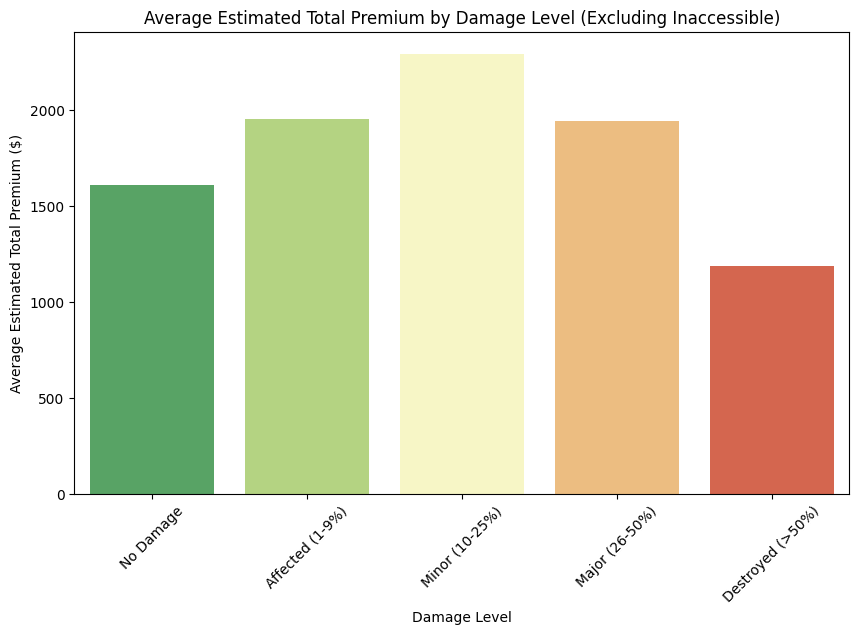

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the estimated total premium using earned premium and exposure
data['Estimated_Total_Premium'] = data['EARNED_PREMIUM'] / data['EARNED_EXPOSURE']

# Prepare data: Filter and aggregate relevant data
grouped_data = data.groupby(['ZIP_CODE', '* Damage']).agg(
    avg_premium=('EARNED_PREMIUM', 'mean'),
    avg_fire_cov_A=('AVG_FIRE_COV_A', 'mean'),
    avg_fire_cov_C=('AVG_FIRE_COV_C', 'mean'),
    count=('OBJECTID', 'count')
).reset_index()

# Define the corrected order for damage severity based on the dataset, excluding 'Inaccessible'
corrected_damage_order = [
    'No Damage',
    'Affected (1-9%)',
    'Minor (10-25%)',
    'Major (26-50%)',
    'Destroyed (>50%)'
]

# Filter and re-order the data based on corrected damage severity
filtered_premium_by_damage = data[data['* Damage'].isin(corrected_damage_order)]
filtered_premium_by_damage['* Damage'] = pd.Categorical(
    filtered_premium_by_damage['* Damage'],
    categories=corrected_damage_order,
    ordered=True
)

# Re-group the data with the corrected categories
premium_by_damage_corrected = filtered_premium_by_damage.groupby('* Damage').agg(
    avg_estimated_premium=('Estimated_Total_Premium', 'mean')
).reset_index()

# Define a gradient color palette from green to red
palette = sns.color_palette("RdYlGn_r", len(corrected_damage_order))  # 'r' reverses the palette for left-to-right

# Plot: Average Estimated Total Premium by Damage Level with corrected order
plt.figure(figsize=(10, 6))
sns.barplot(
    x='* Damage',
    y='avg_estimated_premium',
    data=premium_by_damage_corrected,
    order=corrected_damage_order,
    palette=palette
)
plt.title('Average Estimated Total Premium by Damage Level (Excluding Inaccessible)')
plt.xlabel('Damage Level')
plt.ylabel('Average Estimated Total Premium ($)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
damage_analysis = filtered_premium_by_damage.groupby('* Damage').agg(
    count=('OBJECTID', 'count'),
    avg_estimated_premium=('Estimated_Total_Premium', 'mean'),
    median_estimated_premium=('Estimated_Total_Premium', 'median'),
    total_coverage_A=('AVG_FIRE_COV_A', 'sum'),
    avg_coverage_A=('AVG_FIRE_COV_A', 'mean')
).reset_index()

damage_analysis

<ipython-input-9-4fcd8f92d213>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  damage_analysis = filtered_premium_by_damage.groupby('* Damage').agg(


,* Damage,count,avg_estimated_premium,median_estimated_premium,total_coverage_A,avg_coverage_A
0,No Damage,14728,1609.586383,1418.304792,7.190558e+09,488223.689193
1,Affected (1-9%),1509,1951.050765,1332.783391,9.600149e+08,636192.792200
2,Minor (10-25%),399,2292.692025,1431.868829,2.935658e+08,735753.954486
3,Major (26-50%),160,1941.485029,1351.861780,9.926854e+07,620428.402125
4,Destroyed (>50%),23180,1186.027035,1097.344522,8.257022e+09,356213.190634


### Findings

Properties with minor damage have higher average ($2,292) and median premiums ($1,432) than destroyed properties($1,186 and $1,097, respectively), likely due to policyholders with minor damage holding more comprehensive insurance. The high frequency of destroyed properties (23,180 incidents vs. 399 minor) suggests that lower-cost policies may dilute the average premium in the destroyed category. Additionally, risk mitigation measures and higher average coverage for minor damage properties contribute to the unexpected premium differences.

<ipython-input-10-bda9e6491a3f>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparison_data_all = filtered_premium_by_damage.groupby('* Damage').agg(
<ipython-input-10-bda9e6491a3f>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='* Damage', y='avg_year_built', data=comparison_data_all, palette='Greens', order=corrected_damage_order)


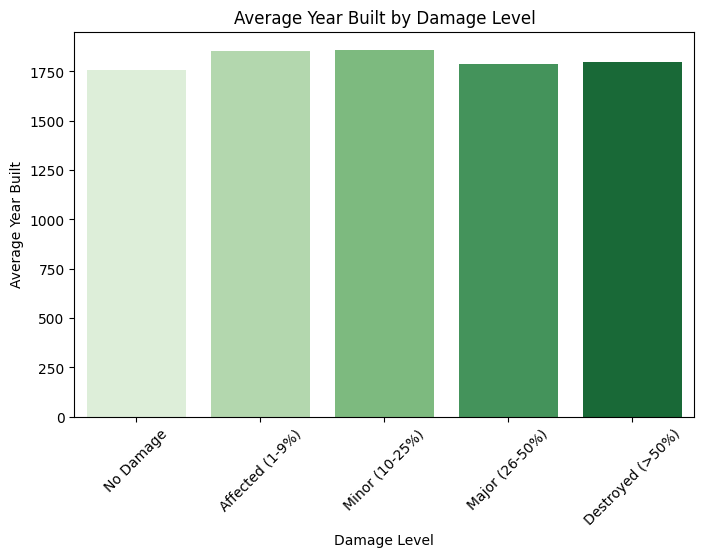

<ipython-input-10-bda9e6491a3f>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='* Damage', y='avg_improved_value', data=comparison_data_all, palette='Purples', order=corrected_damage_order)


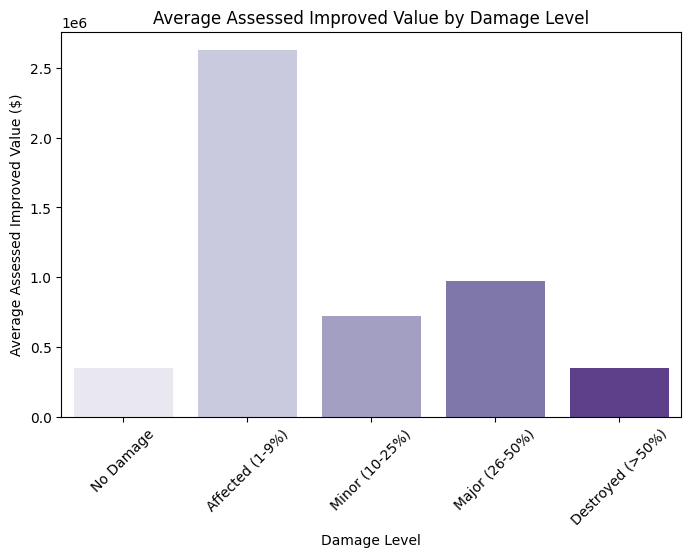

In [ ]:
# Filter and group the data to include all five damage categories (excluding "Inaccessible")
comparison_data_all = filtered_premium_by_damage.groupby('* Damage').agg(
    avg_coverage_A=('AVG_FIRE_COV_A', 'mean'),
    avg_year_built=('Year Built (parcel)', 'mean'),
    avg_improved_value=('Assessed Improved Value (parcel)', 'mean'),
    roof_features_count=('* Roof Construction', 'count'),
    eaves_count=('* Eaves', 'count'),
    vent_screen_count=('* Vent Screen', 'count'),
    exterior_siding_count=('* Exterior Siding', 'count')
).reset_index()

# Plot 2: Average Year Built by Damage Level
plt.figure(figsize=(8, 5))
sns.barplot(x='* Damage', y='avg_year_built', data=comparison_data_all, palette='Greens', order=corrected_damage_order)
plt.title('Average Year Built by Damage Level')
plt.xlabel('Damage Level')
plt.ylabel('Average Year Built')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Average Assessed Improved Value by Damage Level
plt.figure(figsize=(8, 5))
sns.barplot(x='* Damage', y='avg_improved_value', data=comparison_data_all, palette='Purples', order=corrected_damage_order)
plt.title('Average Assessed Improved Value by Damage Level')
plt.xlabel('Damage Level')
plt.ylabel('Average Assessed Improved Value ($)')
plt.xticks(rotation=45)
plt.show()

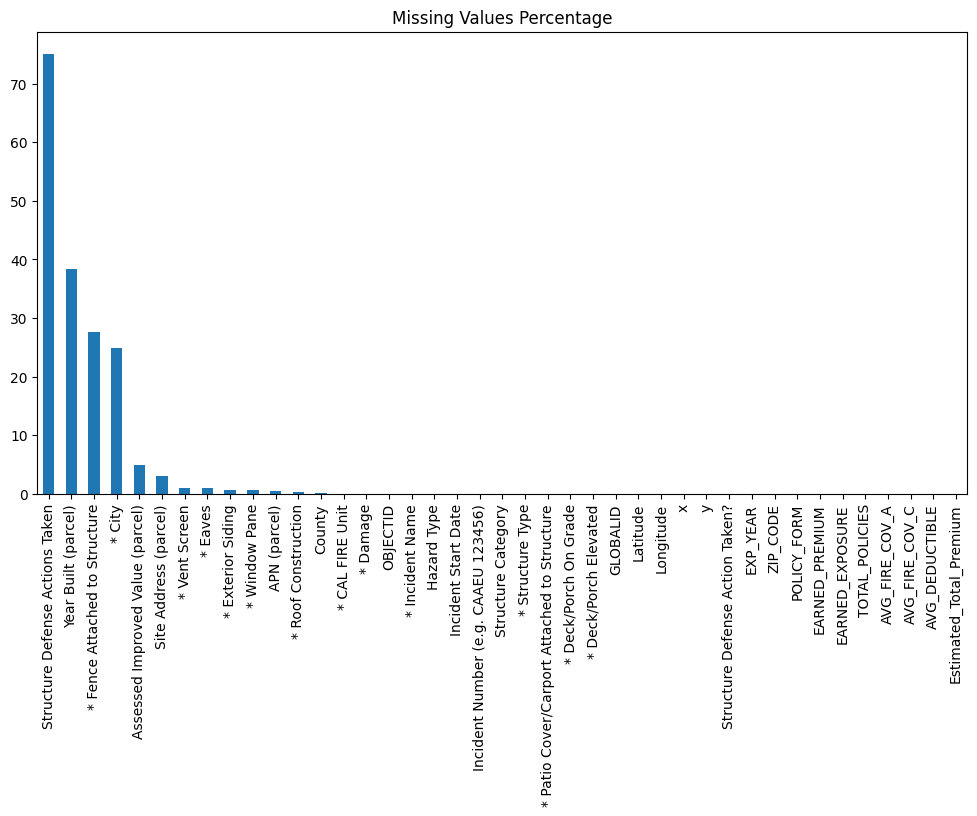

In [ ]:
missing_values = data.isnull().mean() * 100
missing_values.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Missing Values Percentage")
plt.show()

In [ ]:
low_variability_cols = [col for col in data.columns if data[col].nunique() == 1]
print("Columns with low variability:", low_variability_cols)

Columns with low variability: ['Hazard Type']


In [ ]:
# Check duplicate columns
duplicate_cols = data.T[data.T.duplicated()].index.tolist()
print("Potential duplicate columns:", duplicate_cols)

Potential duplicate columns: []


Checking columns that have too many unique values.

In [51]:
for col in ['OBJECTID', 'Incident Number (e.g. CAAEU 123456)', 'GLOBALID', 'APN (parcel)', 'Site Address (parcel)']:
    print(f"{col}: {data[col].nunique()} unique values out of {len(data)} rows")

OBJECTID: 40059 unique values out of 40059 rows
Incident Number (e.g. CAAEU 123456): 171 unique values out of 40059 rows
GLOBALID: 40059 unique values out of 40059 rows
APN (parcel): 33257 unique values out of 40059 rows
Site Address (parcel): 31898 unique values out of 40059 rows


In [64]:
damage_by_incident = data.groupby("Incident Number (e.g. CAAEU 123456)")["* Damage"].nunique()
print(damage_by_incident.value_counts())

* Damage
1    55
2    44
4    26
3    22
5    15
6     9
Name: count, dtype: int64


Most incident numbers have one damage type (1) so will not be the best predictor.

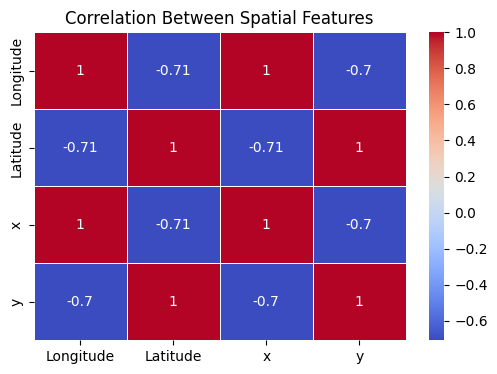

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt


spatial_cols = ["Longitude", "Latitude", "x", "y"]
corr_matrix = data[spatial_cols].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Spatial Features")
plt.show()

Perfect correlation points to redundancy. Will drop columns due to this.

In [66]:
# skewness for all numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
skewness = data[numerical_cols].skew().sort_values(ascending=False)

# Display highly skewed features (absolute skew > 1 is considered highly skewed)
print(skewness[abs(skewness) > 1])

Assessed Improved Value (parcel)    54.623077
AVG_FIRE_COV_A                       2.943591
AVG_DEDUCTIBLE                       2.689345
AVG_FIRE_COV_C                       1.892483
EARNED_PREMIUM                       1.777804
Longitude                            1.153070
x                                    1.153070
y                                   -1.361013
Latitude                            -1.410433
ZIP_CODE                            -1.915955
Year Built (parcel)                 -2.757662
dtype: float64


In [67]:
categorical_cols = data.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    print(f"\nFeature: {col}")
    print(data[col].value_counts(normalize=True))  # percentage distribution



Feature: * Damage
* Damage
Destroyed (>50%)    0.578646
No Damage           0.367658
Affected (1-9%)     0.037669
Minor (10-25%)      0.009960
Major (26-50%)      0.003994
Inaccessible        0.002072
Name: proportion, dtype: float64

Feature: * City
* City
Unincorporated          0.242281
Santa Rosa              0.072638
Magalia                 0.042693
South Lake Tahoe        0.034526
Paradise Northwest B    0.027322
                          ...   
Beaumont                0.000033
#31                     0.000033
Kernville               0.000033
Grizzly Flat            0.000033
 Grizzly Flats          0.000033
Name: proportion, Length: 307, dtype: float64

Feature: * CAL FIRE Unit
* CAL FIRE Unit
BTU    0.308795
LNU    0.243890
AEU    0.086872
LMU    0.056616
SHU    0.044584
CZU    0.040590
LAC    0.033326
ORC    0.028433
FKU    0.021493
VNC    0.020670
TCU    0.014154
KRN    0.012606
SKU    0.010959
NEU    0.010509
TUU    0.010460
MEU    0.010060
MVU    0.009536
BEU    0.007164
MM

Structure Category - 98% of values are the same, adds no real information. Will address class imbalance in oversampling in later steps.

# Preprocessing for Modeling

In [347]:
data['* Damage'] = data['* Damage'].astype("category")

Removing * in front of column names

In [348]:
data.columns = [col[2:] if col.startswith("* ") else col for col in data.columns]
print(data.columns)

Index(['OBJECTID', 'Damage', 'City', 'CAL FIRE Unit', 'County',
       'Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type', 'Structure Defense Actions Taken',
       'Structure Type', 'Structure Category', 'Roof Construction', 'Eaves',
       'Vent Screen', 'Exterior Siding', 'Window Pane', 'Deck/Porch On Grade',
       'Deck/Porch Elevated', 'Patio Cover/Carport Attached to Structure',
       'Fence Attached to Structure', 'APN (parcel)',
       'Assessed Improved Value (parcel)', 'Year Built (parcel)',
       'Site Address (parcel)', 'GLOBALID', 'Latitude', 'Longitude', 'x', 'y',
       'Structure Defense Action Taken?', 'EXP_YEAR', 'ZIP_CODE',
       'POLICY_FORM', 'EARNED_PREMIUM', 'EARNED_EXPOSURE', 'TOTAL_POLICIES',
       'AVG_FIRE_COV_A', 'AVG_FIRE_COV_C', 'AVG_DEDUCTIBLE'],
      dtype='object')


## Dropping Columns with Minimum Predictive Power

*   **Dropping columns for large % of missing values:** Structure Defense Actions Taken
*   **Acts as unique ID:**  OBJECTID, GLOBALID, APN (parcel), Site Address (parcel), Incident Number (e.g. CAAEU 123456)
*  **Redundant columns:** x, y
* **Highly Skewed**: Structure Category



In [349]:
data.drop('Structure Defense Actions Taken', axis=1, inplace=True)

data.drop('OBJECTID', axis=1, inplace=True)
data.drop('GLOBALID', axis=1, inplace=True)
data.drop('Site Address (parcel)', axis=1, inplace=True)
data.drop('APN (parcel)', axis=1, inplace=True)
data.drop('Incident Number (e.g. CAAEU 123456)', axis=1, inplace=True)

data.drop('x', axis=1, inplace=True)
data.drop('y', axis=1, inplace=True)

data.drop('Structure Category', axis=1, inplace=True)

In [350]:
data['month'] = pd.DatetimeIndex(data['Incident Start Date']).month
data.drop('Incident Start Date', axis=1, inplace=True)

In [351]:
data.head(3)

,Damage,City,CAL FIRE Unit,County,Incident Name,Hazard Type,Structure Type,Roof Construction,Eaves,Vent Screen,...,EXP_YEAR,ZIP_CODE,POLICY_FORM,EARNED_PREMIUM,EARNED_EXPOSURE,TOTAL_POLICIES,AVG_FIRE_COV_A,AVG_FIRE_COV_C,AVG_DEDUCTIBLE,month
0,No Damage,Winters,LNU,Solano,Quail,Fire,Single Family Residence Multi Story,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",...,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99,6
1,Affected (1-9%),Winters,LNU,Solano,Quail,Fire,Single Family Residence Single Story,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",...,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99,6
2,No Damage,Winters,LNU,Solano,Quail,Fire,Single Family Residence Single Story,Asphalt,Enclosed,"Mesh Screen > 1/8""""",...,2020,95688,HO,11443912.0,9163.61,9890.0,527226.94,364522.49,1682.99,6


In [352]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40059 entries, 0 to 40058
Data columns (total 31 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Damage                                     40059 non-null  category
 1   City                                       30122 non-null  object  
 2   CAL FIRE Unit                              40059 non-null  object  
 3   County                                     40033 non-null  object  
 4   Incident Name                              40059 non-null  object  
 5   Hazard Type                                40059 non-null  object  
 6   Structure Type                             40059 non-null  object  
 7   Roof Construction                          39904 non-null  object  
 8   Eaves                                      39690 non-null  object  
 9   Vent Screen                                39683 non-null  object  
 10  Exterior S

# XGBoost Model -- Baseline & Feature Importance

In [246]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [248]:
label_encoder = LabelEncoder()
train['Damage'] = label_encoder.fit_transform(train['Damage'])
test['Damage'] = label_encoder.transform(test['Damage'])

# Split features and labels
X_train = train.drop(columns=['Damage', 'Damage'])  # Feature columns
y_train = train['Damage']  # Target column
X_test = test.drop(columns=['Damage', 'Damage'])  # Feature columns
y_test = test['Damage']  # Target column

In [249]:
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Create DMatrix with enable_categorical set to True so categorical variables don't have to be transformed
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [250]:
params = {
    'objective': 'multi:softmax',  # Predict class labels directly
    'num_class': len(label_encoder.classes_),  # Number of unique classes
    'eval_metric': 'mlogloss'  # Multiclass log loss
}

In [251]:
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=10, verbose_eval=False)

In [252]:
y_pred = bst.predict(dtest)
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))
y_test_labels = label_encoder.inverse_transform(y_test.astype(int))

In [253]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_test_labels, y_pred_labels))

Accuracy: 76.40%
              precision    recall  f1-score   support

           0       0.17      0.41      0.24       462
           1       0.82      0.87      0.85      6935
           2       0.25      0.24      0.25        29
           3       0.00      0.00      0.00        59
           4       0.11      0.10      0.11       111
           5       0.86      0.66      0.74      4422

    accuracy                           0.76     12018
   macro avg       0.37      0.38      0.36     12018
weighted avg       0.80      0.76      0.77     12018



<Figure size 1000x800 with 0 Axes>

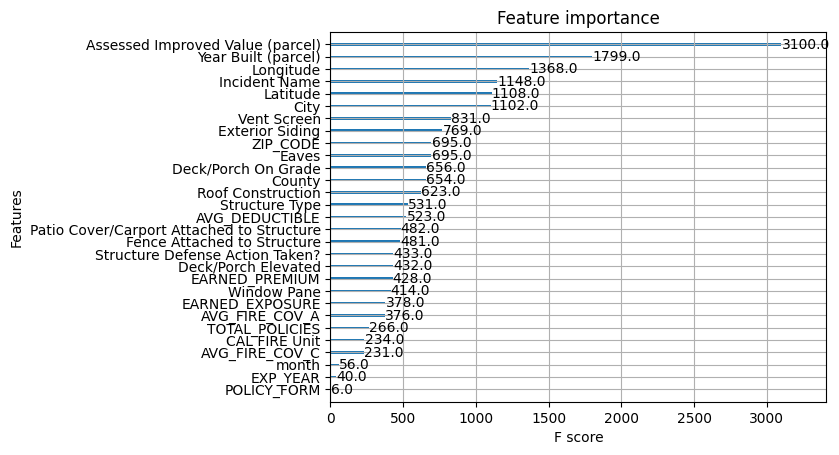

In [254]:
importance = bst.get_score(importance_type='weight')

# Convert importance to a sorted list for better readability
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 8))
xgb.plot_importance(bst, importance_type='weight', max_num_features=len(X_train.columns))
plt.show()

# Further Preprocessing

Adjusting Premiums based on recommendation from industry professional at Cal Insurance.

In [353]:
data['TOTAL_POLICIES'] = data['TOTAL_POLICIES'].replace(0, 1)
data['AVG_FIRE_COV_A'] = data['AVG_FIRE_COV_A'].replace(0, 1)
data['total_fire_cov_a'] = data['TOTAL_POLICIES'] * data['AVG_FIRE_COV_A']

In [354]:
data['prem_per_100k_cov_a'] = np.where(
    (data['total_fire_cov_a'] == 1) | (data['TOTAL_POLICIES'] == 2),
    data['EARNED_PREMIUM'],  # If total_fire_cov_a is 1 or TOTAL_POLICIES is 2, just take earned premium
    (data['EARNED_PREMIUM'] / data['total_fire_cov_a']) * 100000  # Otherwise calculate normally
)

Dropping columns that are redundant due to new columns that were calculated

In [356]:
data.drop('EARNED_EXPOSURE', axis=1, inplace=True)
data.drop('EARNED_PREMIUM', axis=1, inplace=True)
data.drop('AVG_FIRE_COV_A', axis=1, inplace=True)

Remapping target variables to numerical values to improve models interoperability and performance.

In [358]:
data['Damage'] = data['Damage'].replace({'Destroyed (>50%)': 4, 'No Damage': 0, 'Affected (1-9%)': 1,
            'Minor (10-25%)': 2, 'Major (26-50%)': 3, 'Inaccessible': -1})

<ipython-input-358-a41e009a910e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Damage'] = data['Damage'].replace({'Destroyed (>50%)': 4, 'No Damage': 0, 'Affected (1-9%)': 1,
<ipython-input-358-a41e009a910e>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['Damage'] = data['Damage'].replace({'Destroyed (>50%)': 4, 'No Damage': 0, 'Affected (1-9%)': 1,


We removed entries where Damage = -1 ("Inaccessible") because this category is not useful for prediction. Homeowners would typically have access to their properties, making this classification irrelevant for practical decision-making. Additionally, with only 83 instances out of 40,058, this class is highly underrepresented, making it an impractical target for reliable modeling.

In [360]:
data = data[data['Damage'] != -1]

# Filtered Data results in 39,976 Entries

In [361]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39976 entries, 0 to 40058
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Damage                                     39976 non-null  category
 1   City                                       30097 non-null  object  
 2   CAL FIRE Unit                              39976 non-null  object  
 3   County                                     39950 non-null  object  
 4   Incident Name                              39976 non-null  object  
 5   Hazard Type                                39976 non-null  object  
 6   Structure Type                             39976 non-null  object  
 7   Roof Construction                          39821 non-null  object  
 8   Eaves                                      39607 non-null  object  
 9   Vent Screen                                39600 non-null  object  
 10  Exterior Siding

Hazard Type only has one value which is why it wasn't on the feature importance plot. Dropping due to this.

In [362]:
print(data['Hazard Type'].value_counts())

Hazard Type
Fire    39976
Name: count, dtype: int64


In [363]:
data.loc[:, 'Hazard Type'] = None
data.drop('Hazard Type', axis=1, inplace=True)

<ipython-input-363-65134fb5d205>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Hazard Type', axis=1, inplace=True)


### Taking a look at cardinality for categorical varaibles.

Dropping city since it is a high-cardinality categorial variable which can lead to overfitting.

In [364]:
data["City"].nunique()

307

In [365]:
data.loc[:, 'City'] = None
data.drop('City', axis=1, inplace=True)

<ipython-input-365-25af38966420>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('City', axis=1, inplace=True)


Adjusting incident name to binary variable (high impact incident or not) due to high cardinality

In [366]:
num_unique_incidents = data["Incident Name"].nunique()
total_entries = len(data)

print(f"Unique Incident Names: {num_unique_incidents}")
print(f"Total Entries: {total_entries}")
print(f"Percentage of Unique Values: {num_unique_incidents / total_entries:.2%}")

Unique Incident Names: 165
Total Entries: 39976
Percentage of Unique Values: 0.41%


In [367]:
incident_counts = data["Incident Name"].value_counts()

print(incident_counts.describe())

count      165.000000
mean       242.278788
std       1001.585472
min          1.000000
25%          2.000000
50%         14.000000
75%        101.000000
max      11529.000000
Name: count, dtype: float64


In [368]:
high_impact_count = (incident_counts > 500).sum()
low_impact_count = (incident_counts <= 500).sum()

print(f"Incidents with >500 occurrences: {high_impact_count}")
print(f"Incidents with ≤500 occurrences: {low_impact_count}")


Incidents with >500 occurrences: 18
Incidents with ≤500 occurrences: 147


In [369]:
# total occurrences of incidents
total_occurrences = incident_counts.sum()

# proportion of occurrences covered by incidents > 500
high_impact_proportion = incident_counts[incident_counts > 500].sum() / total_occurrences * 100

print(f"Percentage of total dataset covered by high-impact incidents (>500 occurrences): {high_impact_proportion:.2f}%")


Percentage of total dataset covered by high-impact incidents (>500 occurrences): 83.44%


In [370]:
incident_counts = data['Incident Name'].value_counts()
data['high_impact_incident'] = data['Incident Name'].map(lambda x: 1 if incident_counts[x] > 500 else 0) #1 is yes 0 is no

<ipython-input-370-e227352578cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_impact_incident'] = data['Incident Name'].map(lambda x: 1 if incident_counts[x] > 500 else 0) #1 is yes 0 is no


In [371]:
data.drop('Incident Name', axis=1, inplace=True)

<ipython-input-371-c0b709309663>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Incident Name', axis=1, inplace=True)


In [372]:
data.columns

Index(['Damage', 'CAL FIRE Unit', 'County', 'Structure Type',
       'Roof Construction', 'Eaves', 'Vent Screen', 'Exterior Siding',
       'Window Pane', 'Deck/Porch On Grade', 'Deck/Porch Elevated',
       'Patio Cover/Carport Attached to Structure',
       'Fence Attached to Structure', 'Assessed Improved Value (parcel)',
       'Year Built (parcel)', 'Latitude', 'Longitude',
       'Structure Defense Action Taken?', 'EXP_YEAR', 'ZIP_CODE',
       'POLICY_FORM', 'TOTAL_POLICIES', 'AVG_FIRE_COV_C', 'AVG_DEDUCTIBLE',
       'month', 'total_fire_cov_a', 'prem_per_100k_cov_a',
       'high_impact_incident'],
      dtype='object')

# Prepare for modeling

In [385]:
cols_to_encode = ['CAL FIRE Unit', 'County', 'Structure Type',
       'Roof Construction', 'Eaves', 'Vent Screen', 'Exterior Siding',
       'Window Pane', 'Deck/Porch On Grade', 'Deck/Porch Elevated',
       'Patio Cover/Carport Attached to Structure',
       'Fence Attached to Structure']

def label_encode(df, category):
    label_encoder = LabelEncoder()
    df.loc[:, category] = label_encoder.fit_transform(df[category].astype(str))

In [386]:
for c in cols_to_encode:
    label_encode(data, c)

In [387]:
label_encode(data, 'Structure Defense Action Taken?')
label_encode(data, 'POLICY_FORM')

In [388]:
data['Damage'] = data['Damage'].astype(int)

<ipython-input-388-761f2acccf84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Damage'] = data['Damage'].astype(int)


In [389]:
x2 = data.drop('Damage', axis=1)
y2 = data[['Damage']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
X_train2.columns = [str(col) for col in X_train2.columns]
X_test2.columns = [str(col) for col in X_test2.columns]
X_train2.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train2.columns]
X_test2.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_test2.columns]

In [390]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

model3 = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y2)), eval_metric='mlogloss', n_estimators=100,
                       random_state=42)
model3.fit(X_train2, y_train2)

y_pred2 = model3.predict(X_test2)
print(f" Train Acc: {accuracy_score(y_train2, model3.predict(X_train2))}")
accuracy = accuracy_score(y_test2, y_pred2)
print(f"Test Acc: {accuracy:.4f}")
report = classification_report(y_test2, y_pred2)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:\n", cm)

print(f"Classification Report: \n{report}")

 Train Acc: 0.9835209505941214
Test Acc: 0.9388
Confusion Matrix:
 [[2893    4    0    0   57]
 [  65  144   16    7   85]
 [   8   24   14    2   25]
 [   3   16    0    2    6]
 [ 133   28    5    5 4454]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2954
           1       0.67      0.45      0.54       317
           2       0.40      0.19      0.26        73
           3       0.12      0.07      0.09        27
           4       0.96      0.96      0.96      4625

    accuracy                           0.94      7996
   macro avg       0.62      0.53      0.56      7996
weighted avg       0.93      0.94      0.93      7996



Train and Test Accuracy are good and are close in value, so model generalizes well. However, there is clearly a class imbalance in the predictions. Will process with SMOTE to oversample minority classes.

# Applying SMOTE to address class imbalance

In [391]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import numpy as np

# Handling missing data
imputer = SimpleImputer(strategy="median")  # Use median imputation for numerical features
X_train_imputed = imputer.fit_transform(X_train2)
X_test_imputed = imputer.transform(X_test2)

# Applying SMOTE for oversampling minority classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train2)

# Initialize model
model3 = XGBClassifier(objective='multi:softmax',
                       num_class=len(np.unique(y_train_resampled)),
                       eval_metric='mlogloss',
                       n_estimators=100,
                       random_state=42)


model3.fit(X_train_resampled, y_train_resampled)


y_pred2 = model3.predict(X_test_imputed)


print(f"Train Acc: {accuracy_score(y_train_resampled, model3.predict(X_train_resampled)):.4f}")
print(f"Test Acc: {accuracy_score(y_test2, y_pred2):.4f}")


cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:\n", cm)


report = classification_report(y_test2, y_pred2)
print(f"Classification Report: \n{report}")


Train Acc: 0.9821
Test Acc: 0.9348
Confusion Matrix:
 [[2876   10    2    0   66]
 [  61  130   26   12   88]
 [   8   27   14    5   19]
 [   3   14    2    2    6]
 [ 126   32    6    8 4453]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2954
           1       0.61      0.41      0.49       317
           2       0.28      0.19      0.23        73
           3       0.07      0.07      0.07        27
           4       0.96      0.96      0.96      4625

    accuracy                           0.93      7996
   macro avg       0.57      0.52      0.54      7996
weighted avg       0.93      0.93      0.93      7996



# Model with 3 Damage Categories

The advisor recommended consolidating the categories from five to three to address class imbalance. Additionally, from a business perspective, simplifying the classification into No Damage, Moderate Damage, and Severe Damage aligns better with user expectations and decision-making needs.

In [392]:
final_few = data.copy()

In [393]:

final_few.columns = final_few.columns.str.replace('[*?"" ]+', '', regex=True)  # Remove unwanted characters
final_few.columns = final_few.columns.str.replace('/', 'or')  # Replace '/' with 'or'
final_few.columns = final_few.columns.str.replace(r'<=', '_lessthanorequal_', regex=True)
final_few.columns = final_few.columns.str.replace(r'>', '_greaterthan_', regex=True)
final_few.columns = final_few.columns.str.replace(r'[()\[\]]', '', regex=True)  # Remove remaining special characters
final_few.columns = final_few.columns.str.replace(r'\s+', '_', regex=True)  # Replace spaces with underscores


## Creating 3 Damage Categories

In [394]:
final_few['Damage'] = final_few['Damage'].replace(2, 1) # Merge "Minor (10-25%)" into "Affected (1-9%)"
final_few['Damage'] = final_few['Damage'].replace(3, 1) # Merge "Major (26-50%)" into "Affected (1-9%)"
final_few['Damage'] = final_few['Damage'].replace(4, 2) # Keep "Destroyed (>50%)" as a separate category
final_few['Damage'].value_counts()

,count
Damage,
2,23180
0,14728
1,2068


In [395]:
x = final_few.drop('Damage', axis=1)
y = final_few[['Damage']]

In [396]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
X_test.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_test.columns]

In [397]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [398]:
model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss',random_state=42, subsample = 1.0, reg_lambda = 0.1, reg_alpha = 1.0, n_estimators = 100, max_depth = 10, learning_rate = 0.2, gamma = 0, colsample_bytree = 0.6)
model.fit(X_train_scaled, y_train)
print(f" Train Acc: {accuracy_score(y_train, model.predict(X_train_scaled))}")
print(f"Test Acc: {accuracy_score(y_test, model.predict(X_test_scaled)):.4f}")
print(confusion_matrix(y_test, model.predict(X_test_scaled)))


 Train Acc: 0.9974671669793621
Test Acc: 0.9497
[[2882   13   59]
 [  74  240  103]
 [ 110   43 4472]]


In [399]:
print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2954
           1       0.81      0.58      0.67       417
           2       0.97      0.97      0.97      4625

    accuracy                           0.95      7996
   macro avg       0.91      0.84      0.87      7996
weighted avg       0.95      0.95      0.95      7996



# RandomizedSearchCV to find best hyperparameters for model

In [210]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0]
}

xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)
# Fit the random search model
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best accuracy score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Accuracy Score: {random_search.best_score_:.4f}")

# Train the model with the best parameters on the full training data
best_model = random_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Evaluate the tuned model
print(f"Tuned Train Acc: {accuracy_score(y_train, best_model.predict(X_train_scaled))}")
print(f"Tuned Test Acc: {accuracy_score(y_test, best_model.predict(X_test_scaled)):.4f}")
print(confusion_matrix(y_test, best_model.predict(X_test_scaled)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best Accuracy Score: 0.9473
Tuned Train Acc: 0.983552220137586
Tuned Test Acc: 0.9510
[[2892    5   57]
 [  77  234  106]
 [ 110   37 4478]]


In [211]:
print(classification_report(y_test, best_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2954
           1       0.85      0.56      0.68       417
           2       0.96      0.97      0.97      4625

    accuracy                           0.95      7996
   macro avg       0.92      0.84      0.87      7996
weighted avg       0.95      0.95      0.95      7996



At this point of the pipeline, we utilized AWS Sagemaker models. Please reach out for any further code.